<span style="font-size: 14pt">MIPT, TS forecasting in Retail, Autumn 2017</span>

<span style="font-size: 16pt"> Training ES models </span>

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>d

## Select best ES model for each TS 

* I.   Download datasets <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">TS_dep36.csv</span> 
     
* II. Define the train period and validate period
    
* III. For TS_dep36.csv Find the best ES algorithm on Validate Period:
     
    - 0) Use only following ES models: IES (see seminar 2), AES (see seminar 2), Winters with additive seasonality (see Practice Day 1 task 3), Theil-Wage.
    - 1) forecasting delay $h = 1$, loss function is MACAPE;
    - 2) forecast each TS by each ES Model with optimal params using Validate Period (for ES model Validate Period = Train Period) (for TS_dep36.csv from 12.05.2005 to 30.04.2006);
    
    - 3) find the optimal ES algorithm. You need to remember optimal ES algorithm for each TS!
    
    - 4) Build barchar (histogram) of losses of optimal ES algorithm (were calulated at step before) for all TS (axis x - value of loss, axis y - percentage of TS that have such loss). Here you must exclude those TS which has only NaNs in period under consideration.
            
* IV.Compare Forecast on Validate Period and Test Period (for TS_dep36.csv from 12.05.2005 to 13.06.2006). 
       
    - 1) Measure accuracy (loss) of forecast for each TS using dates that were not used in step 2)-3) (for TS_dep36.csv from 12.05.2005 to 30.04.2006), here you must exclude those TS which has only NaNs in the end.
    
    - 2) Build barchar (histogram) of losses of optimal ES algorithm for all TS (axis x - value of loss, axis y - percentage of TS that has such loss), here you must exclude those TS which has only NaNs in period under consideration.

In [1]:
import pandas as pd
import math
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from IPython import display
import statsmodels.api as sm
from utils import qualityMACAPE, build_forecast, plot_tsforecast
from utils import InitExponentialSmoothing, AdaptiveExponentialSmoothing, WintersExponentialSmoothing, TWExponentialSmoothing
%matplotlib inline

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## I. Download datasets 

In [2]:
# Read data
ts = pd.read_csv('./data/TS_dep36.csv', sep=';', decimal=',', index_col='Timestamp', parse_dates=True, dayfirst=True)

## II. Define the train period and validate period

* Train Period (for ESM models is not necessary) '2005-05-01' - '2005-11-01'
* Validate Period '2005-11-01'-'2006-04-30'

## III. Find the best ES algorithm for each ts on Validate Period

In [3]:
# Forecast with IES
ALPHA = np.linspace(0,1,11)
es_params_array = [{'alpha':alpha, 'AdaptationPeriod':10} for alpha in ALPHA]
IES_FRC_TS = build_forecast(h=1, ts=ts, algname =  'InitExponentialSmoothing', algtitle='IES' ,params_array = es_params_array)

In [4]:
# Forecast with AES
GAMMA = np.linspace(0,1,11)
aes_params_array = [{'gamma':gamma, 'alpha':0.1, 'AdaptationPeriod':10} for gamma in GAMMA]
AES_FRC_TS = build_forecast(h=1, ts=ts, algname =  'AdaptiveExponentialSmoothing', algtitle='AES' ,params_array = aes_params_array)

In [5]:
# Forecast with WES
GAMMA = np.linspace(0,1,11)
wes_params_array = [{'gamma':gamma, 'alpha':0.1, 'AdaptationPeriod':10, 'seasonality_period':7} for gamma in GAMMA]
WES_FRC_TS = build_forecast(h=1, ts=ts, algname =  'WintersExponentialSmoothing', algtitle='WES' ,params_array = wes_params_array)

In [6]:
# Forecast with TWES
GAMMA = np.linspace(0,1,11)
twes_params_array = [{'beta':beta, 'gamma':gamma, 'alpha':0.1, 'AdaptationPeriod':10, 'seasonality_period':7} for gamma in GAMMA for beta in GAMMA]
TWES_FRC_TS = build_forecast(h=1, ts=ts, algname =  'WintersExponentialSmoothing', algtitle='TWES' ,params_array = twes_params_array)

In [8]:
# Calculate Quality of Prediction on Validation Period
ALL_FRC_TS = {**IES_FRC_TS,**AES_FRC_TS,**WES_FRC_TS,**TWES_FRC_TS}

# Validation Period
ix = ts.loc['2005-11-01':'2006-04-30'].index

validate_quality = pd.DataFrame(index = ts.columns, columns = ALL_FRC_TS.keys())
for param_cntr in sorted(validate_quality.columns):
    frc_wage = ALL_FRC_TS[param_cntr]
    validate_quality[param_cntr],_ = qualityMACAPE(ts.loc[ix], ALL_FRC_TS[param_cntr].loc[ix])

In [9]:
# best algs in average
validate_quality[validate_quality.columns].mean().sort_values()[:5]

TWES {'beta': 0.5, 'gamma': 0.0, 'alpha': 0.1, 'AdaptationPeriod': 10, 'seasonality_period': 7}                    0.7095
WES {'gamma': 0.0, 'alpha': 0.1, 'AdaptationPeriod': 10, 'seasonality_period': 7}                                  0.7095
TWES {'beta': 1.0, 'gamma': 0.0, 'alpha': 0.1, 'AdaptationPeriod': 10, 'seasonality_period': 7}                    0.7095
TWES {'beta': 0.90000000000000002, 'gamma': 0.0, 'alpha': 0.1, 'AdaptationPeriod': 10, 'seasonality_period': 7}    0.7095
TWES {'beta': 0.80000000000000004, 'gamma': 0.0, 'alpha': 0.1, 'AdaptationPeriod': 10, 'seasonality_period': 7}    0.7095
dtype: float64

## Find best algorithm for each TS

In [27]:
validate_quality[validate_quality<0]=np.NAN
best_alg = pd.DataFrame(index=ts.columns, columns = {'Loss', 'best_alg'},
        data=[(validate_quality.loc[item].sort_values().index[0], validate_quality.loc[item].sort_values()[0] ) for item in ts.columns])
best_alg.head()

,best_alg,Loss
item 1758,"TWES {'beta': 1.0, 'gamma': 1.0, 'alpha': 0.1,...",0.586716
item 40010,"AES {'gamma': 0.0, 'alpha': 0.1, 'AdaptationPe...",0.959692
item 35731,"TWES {'beta': 0.80000000000000004, 'gamma': 0....",0.694606
item 96474,"TWES {'beta': 0.0, 'gamma': 0.1000000000000000...",0.603222
item 97519,"IES {'alpha': 0.10000000000000001, 'Adaptation...",0.907805


In [29]:
# Exclude TS where all values were NaN
best_alg.loc[~np.isnan(best_alg.loc[:,'Loss'])].head()

,best_alg,Loss
item 1758,"TWES {'beta': 1.0, 'gamma': 1.0, 'alpha': 0.1,...",0.586716
item 40010,"AES {'gamma': 0.0, 'alpha': 0.1, 'AdaptationPe...",0.959692
item 35731,"TWES {'beta': 0.80000000000000004, 'gamma': 0....",0.694606
item 96474,"TWES {'beta': 0.0, 'gamma': 0.1000000000000000...",0.603222
item 97519,"IES {'alpha': 0.10000000000000001, 'Adaptation...",0.907805


## Build barchar (histogram) of losses of the optimal ES algorithm
Build the histogram of best Accuracy distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022DAD1305F8>]], dtype=object)

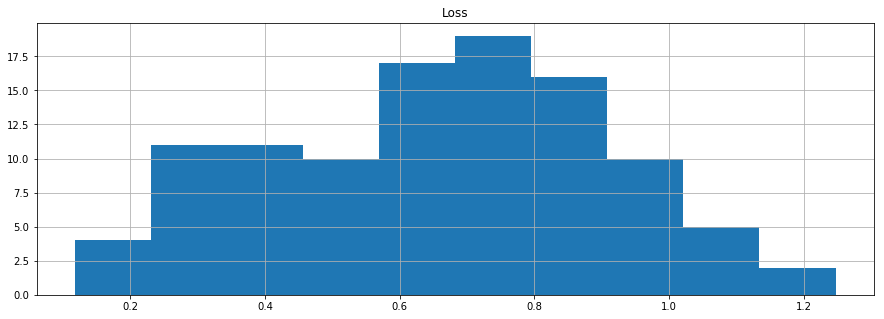

In [30]:
best_alg.loc[~np.isnan(best_alg.loc[:,'Loss']), ['Loss']].hist(figsize=(15,5))

# IV. Compare Forecast on Validate Period and Test Period
Use whole data to make prediction. Note that each TS predicted individually by one's best model.

In [31]:
# Test Period
ix = ts.loc['2006-04-30':'2006-06-13'].index

test_quality = pd.DataFrame(index = ts.columns, columns = ALL_FRC_TS.keys())
for param_cntr in sorted(test_quality.columns):
    frc_wage = ALL_FRC_TS[param_cntr]
    test_quality[param_cntr],_ = qualityMACAPE(ts.loc[ix], ALL_FRC_TS[param_cntr].loc[ix])

In [32]:
test_quality[test_quality<0]=np.NAN
best_alg['Test_Loss'] = [test_quality.loc[item, best_alg.loc[item, 'best_alg']] for item in best_alg.index]

In [33]:
# Exclude TS where all values were NaN
best_alg.loc[(~np.isnan(best_alg.loc[:,'Loss']) & ~np.isnan(best_alg.loc[:,'Test_Loss']))].head()

,best_alg,Loss,Test_Loss
item 1758,"TWES {'beta': 1.0, 'gamma': 1.0, 'alpha': 0.1,...",0.586716,1.118026
item 40010,"AES {'gamma': 0.0, 'alpha': 0.1, 'AdaptationPe...",0.959692,0.940219
item 35731,"TWES {'beta': 0.80000000000000004, 'gamma': 0....",0.694606,1.271564
item 97519,"IES {'alpha': 0.10000000000000001, 'Adaptation...",0.907805,1.027464
item 75501,"TWES {'beta': 1.0, 'gamma': 0.0, 'alpha': 0.1,...",0.319443,0.905749


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022DAD1BDCF8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000022DB0DDDB38>]], dtype=object)

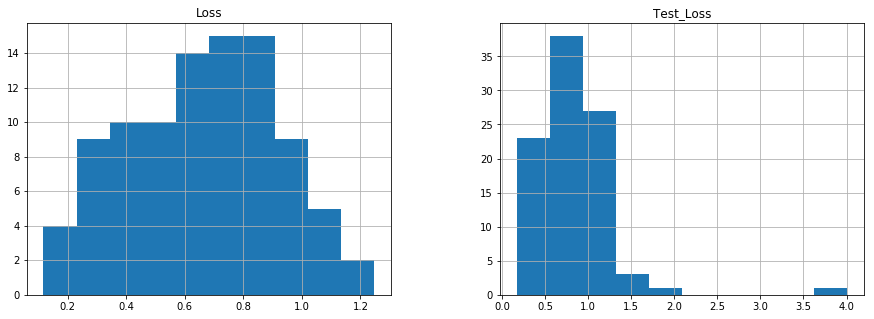

In [34]:
# plot barchar
best_alg.loc[(~np.isnan(best_alg.loc[:,'Loss']) & ~np.isnan(best_alg.loc[:,'Test_Loss'])), ['Loss', 'Test_Loss']].hist(figsize =(15,5))

In [35]:
# statistics to compare losses on validate and test periods
best_alg.loc[(~np.isnan(best_alg.loc[:,'Loss']) & ~np.isnan(best_alg.loc[:,'Test_Loss'])), ['Loss', 'Test_Loss']].agg(
    {'Loss' : [np.min, np.max, np.mean],
        'Test_Loss' : [np.min, np.max, np.mean]})

,Loss,Test_Loss
amin,0.117361,0.168302
amax,1.247511,4.010433
mean,0.671356,0.835555


In [36]:
# quantiles of values
best_alg.quantile([.01, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99, 1]).transpose()

,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99,1.0
Loss,0.167863,0.317747,0.437792,0.524059,0.617298,0.674559,0.768037,0.828420,0.893692,0.969597,1.057033,1.150976,1.247511
Test_Loss,0.239682,0.438047,0.506172,0.606692,0.677839,0.777761,0.854718,0.978452,1.092108,1.220416,1.339406,1.978678,4.010433


** Conclusion **
    * loss on validation period is more optimistic then loss on test period
    * you can 